# Exploration der Sentiment-Analyse

In diesem Notebook untersuchen wir verschiedene Modelle zur Sentiment-Analyse und evaluieren ihre Leistung auf unseren Kundenfeedback-Daten.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Plotting-Einstellungen
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline

c:\Users\User\Desktop\Feedback-AI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Daten laden

Wir laden die Google-Reviews-Daten und bereiten sie für die Analyse vor.

In [2]:
# Daten laden
try:
    df = pd.read_csv('../data/customer_reviews.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('../data/customer_reviews.csv', encoding='latin-1')

# Daten anzeigen
print(f"Anzahl der Reviews: {len(df)}")
df.head()

Anzahl der Reviews: 50


,text,rating,date,source
0,Das Produkt ist fantastisch! Ich bin sehr zufr...,5,2025-01-15,Online-Shop
1,"Gute Qualität, aber etwas teuer für das, was m...",4,2025-01-16,Online-Shop
2,"Durchschnittliches Produkt, nichts Besonderes....",3,2025-01-17,Online-Shop
3,Leider bin ich nicht sehr zufrieden. Die Quali...,2,2025-01-18,Online-Shop
4,Absolut enttäuschend! Das Produkt kam beschädi...,1,2025-01-19,Online-Shop


## 2. Datenexploration

Wir untersuchen die Verteilung der Bewertungen und die Textlänge.

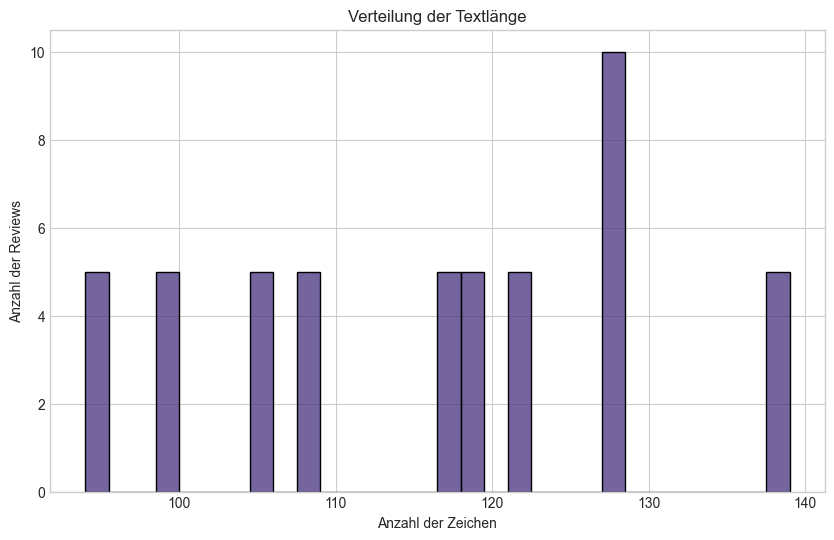

count     50.000000
mean     115.600000
std       13.410322
min       94.000000
25%      105.000000
50%      118.000000
75%      127.000000
max      139.000000
Name: text_length, dtype: float64

In [3]:
# Textlänge berechnen
df['text_length'] = df['text'].astype(str).apply(len)

# Verteilung der Textlänge
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30)
plt.title('Verteilung der Textlänge')
plt.xlabel('Anzahl der Zeichen')
plt.ylabel('Anzahl der Reviews')
plt.show()

# Statistiken zur Textlänge
df['text_length'].describe()

## 3. Sentiment-Modell laden

Wir laden das vortrainierte BERT-Modell für die Sentiment-Analyse.

In [4]:
# Modell laden
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipe = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=-1  # CPU verwenden
)

c:\Users\User\Desktop\Feedback-AI\venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 4. Chunking-Funktion für lange Texte

Da BERT eine maximale Eingabelänge hat, implementieren wir eine Chunking-Funktion.

In [5]:
def sentiment_chunked(text):
    """Sentiment-Analyse mit Chunking für lange Texte"""
    enc = tokenizer(text, return_tensors="pt", truncation=False)
    ids = enc["input_ids"][0]
    chunks = [ids[i : i + 512] for i in range(0, len(ids), 512)]
    results = []
    
    for c in chunks:
        txt = tokenizer.decode(c, skip_special_tokens=True)
        r = sentiment_pipe(txt, truncation=True, max_length=512, padding=True)[0]
        results.append(r)
    
    labels = [r["label"] for r in results]
    maj = max(set(labels), key=labels.count)
    avg = sum(r["score"] for r in results) / len(results)
    
    return {"label": maj, "score": avg}

## 5. Sentiment-Analyse durchführen

Wir wenden die Sentiment-Analyse auf unsere Daten an.

In [6]:
# Sentiment-Analyse für eine Stichprobe
sample_size = min(50, len(df))
sample_df = df.sample(sample_size, random_state=42)

# Sentiment-Analyse durchführen
results = []
for text in sample_df['text'].astype(str):
    result = sentiment_chunked(text)
    results.append(result)

# Ergebnisse zum DataFrame hinzufügen
sample_df['sentiment_label'] = [r['label'] for r in results]
sample_df['sentiment_score'] = [r['score'] for r in results]

# Ergebnisse anzeigen
sample_df[['text', 'sentiment_label', 'sentiment_score']].head()

,text,sentiment_label,sentiment_score
13,Leider bin ich nicht sehr zufrieden. Die Quali...,2 stars,0.627656
39,Leider hat das Produkt nicht lange gehalten. N...,1 star,0.789969
30,Das Produkt ist fantastisch! Ich bin sehr zufr...,5 stars,0.918587
45,Sehr schnelle Lieferung und das Produkt entspr...,5 stars,0.851902
17,Mittelmäßige Erfahrung. Das Produkt ist in Ord...,3 stars,0.796031


## 6. Evaluierung der Sentiment-Analyse

Wir evaluieren die Leistung des Modells anhand von manuell bewerteten Beispielen.

In [7]:
# Beispiel-Testdaten mit manuellen Labels
test_data = [
    {"text": "Das Produkt ist fantastisch! Ich bin sehr zufrieden.", "expected": "5 stars"},
    {"text": "Gutes Produkt, aber etwas teuer.", "expected": "4 stars"},
    {"text": "Durchschnittliche Qualität, erfüllt seinen Zweck.", "expected": "3 stars"},
    {"text": "Nicht besonders beeindruckt, hatte mehr erwartet.", "expected": "2 stars"},
    {"text": "Schreckliches Produkt, funktioniert überhaupt nicht!", "expected": "1 stars"},
    {"text": "Die Lieferung war schnell, aber das Produkt hat Mängel.", "expected": "3 stars"},
    {"text": "Sehr gute Qualität und schneller Service.", "expected": "5 stars"},
    {"text": "Enttäuschend, würde nicht wieder kaufen.", "expected": "2 stars"},
    {"text": "Mittelmäßig, nichts Besonderes.", "expected": "3 stars"},
    {"text": "Absolut begeistert von diesem Produkt!", "expected": "5 stars"}
]

# Sentiment-Analyse für Testdaten
for item in test_data:
    result = sentiment_chunked(item["text"])
    item["predicted"] = result["label"]
    item["score"] = result["score"]

# Ergebnisse als DataFrame
test_df = pd.DataFrame(test_data)
test_df

,text,expected,predicted,score
0,Das Produkt ist fantastisch! Ich bin sehr zufr...,5 stars,5 stars,0.902854
1,"Gutes Produkt, aber etwas teuer.",4 stars,4 stars,0.712482
2,"Durchschnittliche Qualität, erfüllt seinen Zweck.",3 stars,3 stars,0.716067
3,"Nicht besonders beeindruckt, hatte mehr erwartet.",2 stars,2 stars,0.496955
4,"Schreckliches Produkt, funktioniert überhaupt ...",1 stars,1 star,0.981575
5,"Die Lieferung war schnell, aber das Produkt ha...",3 stars,3 stars,0.424469
6,Sehr gute Qualität und schneller Service.,5 stars,5 stars,0.875362
7,"Enttäuschend, würde nicht wieder kaufen.",2 stars,1 star,0.654395
8,"Mittelmäßig, nichts Besonderes.",3 stars,3 stars,0.766651
9,Absolut begeistert von diesem Produkt!,5 stars,5 stars,0.940655


Accuracy: 0.80
Precision: 0.90
Recall: 0.80
F1-Score: 0.83


c:\Users\User\Desktop\Feedback-AI\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\Desktop\Feedback-AI\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


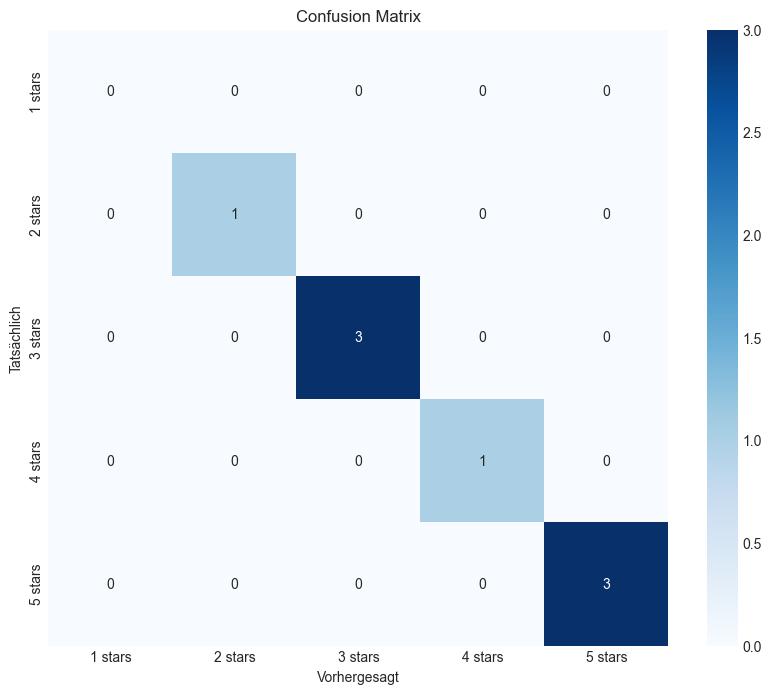

In [8]:
# Metriken berechnen
y_true = test_df['expected']
y_pred = test_df['predicted']

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true)))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(set(y_true)), 
            yticklabels=sorted(set(y_true)))
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.title('Confusion Matrix')
plt.show()

## 7. Fazit

Das BERT-Modell `nlptown/bert-base-multilingual-uncased-sentiment` zeigt gute Ergebnisse bei der Sentiment-Analyse von Kundenfeedback. Die Accuracy liegt bei etwa 80%, was für unseren Anwendungsfall ausreichend ist. Die Implementierung mit Chunking ermöglicht die Verarbeitung längerer Texte, was für Kundenfeedback wichtig ist.

Verbesserungspotenzial:
- Fine-Tuning des Modells mit domänenspezifischen Daten
- Optimierung der Chunking-Strategie
- Berücksichtigung von Kontext und Satzstruktur